In [1]:
import os
import pandas as pd
import wrds
from sqlalchemy import text
import datetime

/Users/ishaanpoojari/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/ishaanpoojari/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
db = wrds.Connection(wrds_username='user2294')

Loading library list...
Done


In [3]:
# Define the directory containing CSV files
directory = 'Quarterly_Segregated'

# Initialize an empty list to store dataframes
dfs = []

# Loop through each file in the directory
for root, dirs, files in os.walk(directory):
    for file in files:
        # Check if the file is a CSV
        if file.endswith('.csv'):
            # Construct the full path to the CSV file
            file_path = os.path.join(root, file)
            # Read the CSV into a dataframe and append it to the list
            df = pd.read_csv(file_path)
            dfs.append(df)

# Concatenate all dataframes into a single dataframe
combined_df = pd.concat(dfs, ignore_index=True)

#kCBF.zEqH5*,6:c


In [4]:
df = combined_df
df

,Filer Name,Stock Name,Stock Ticker,Quarter Date,Type of Security,Current Shares Held,Current Market Value,Previous Shares Held,Previous Market Value,Current % of Portfolio,Previous % of Portfolio,Current Rank,Previous Rank,Change in Shares,Type of Change,Sector,stock_id
0,"PERSHING SQUARE CAPITAL MANAGEMENT, L.P.",J C Penney Company Inc,CPPRQ,2011-03-31,SH,34919071.0,1.253944e+09,34919071.0,1.128235e+09,21.9317,19.3034,1,1,0.000000,NaN,CONSUMER DISCRETIONARY,338
1,"PERSHING SQUARE CAPITAL MANAGEMENT, L.P.",General Growth Properties Inc. (DE),GGP,2011-03-31,SH,71802853.0,1.111509e+09,69965786.0,1.083070e+09,19.4404,18.5306,2,2,2.625665,addition,REAL ESTATE,230
2,"PERSHING SQUARE CAPITAL MANAGEMENT, L.P.",Beam Inc,BEAM,2011-03-31,SH,16668636.0,1.031622e+09,16668636.0,1.004286e+09,18.0432,17.1827,3,3,0.000000,NaN,CONSUMER DISCRETIONARY,503
3,"PERSHING SQUARE CAPITAL MANAGEMENT, L.P.",Mondelez International Inc. (Kraft Foods),MDLZ,2011-03-31,SH,22239265.0,6.974230e+08,19470089.0,6.135020e+08,12.1980,10.4966,4,5,14.222719,addition,CONSUMER STAPLES,3785
4,"PERSHING SQUARE CAPITAL MANAGEMENT, L.P.",Citigroup Inc.,C,2011-03-31,SH,14670777.7,6.484480e+08,14651428.7,6.930130e+08,11.3414,11.8570,5,4,0.132062,addition,FINANCE,216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111092,ICAHN CARL C,Take-Two Interactive Software Inc.,TTWO,2010-09-30,SH,2461124.0,2.495600e+07,2357844.0,2.122100e+07,0.4511,0.4534,12,8,4.380273,addition,INFORMATION TECHNOLOGY,3930
111093,ICAHN CARL C,Dynegy Inc. (DE) Class A,DYNIQ,2010-09-30,SH,2399999.0,1.168800e+07,0.0,0.000000e+00,0.2113,NaN,13,999999,NaN,new,UTILITIES AND TELECOMMUNICATIONS,4078
111094,ICAHN CARL C,Enzon Pharmaceuticals Inc,ENZN,2010-09-30,SH,704214.0,7.922000e+06,704214.0,7.500000e+06,0.1432,0.1602,14,12,0.000000,NaN,HEALTH CARE,6903
111095,ICAHN CARL C,Lions Gate Entertainment Corp,LGF,2010-09-30,PRN,316600.0,3.100000e+05,316600.0,3.070000e+05,0.0056,0.0066,15,13,0.000000,NaN,CONSUMER DISCRETIONARY,679


In [5]:
tickers_list = df['Stock Ticker'].unique().tolist()
dates = df["Quarter Date"].unique().tolist()


# Join formatted dates into a string for SQL query
sql_date_string = ', '.join([f"'{date}'" for date in dates])
sql_ticker_string = ', '.join([f"'{ticker}'" for ticker in tickers_list])


In [6]:
query = f"""
SELECT b.date, a.ticker, b.shrout
FROM crsp.dse a
LEFT JOIN crsp.msf b ON a.cusip = b.cusip
WHERE a.ticker IN ({sql_ticker_string}) AND b.date IN ({sql_date_string})
"""

data_df = db.raw_sql(query)
data_df

,date,ticker,shrout
0,2023-06-30,JJSF,19270.0
1,2023-03-31,JJSF,19252.0
2,2022-09-30,JJSF,19219.0
3,2022-06-30,JJSF,19184.0
4,2022-03-31,JJSF,19173.0
...,...,...,...
381440,2003-06-30,ORCL,5233773.0
381441,2003-03-31,ORCL,5242996.0
381442,2002-12-31,ORCL,5269114.0
381443,2002-09-30,ORCL,5355935.0


In [7]:
data_df.rename(columns={'date': 'Quarter Date', 'ticker': 'Stock Ticker'}, inplace=True)

In [8]:
# Convert 'Quarter Date' column to datetime type
data_df['Quarter Date'] = pd.to_datetime(data_df['Quarter Date'])

# Ensure the 'Stock Ticker' column values are of string type
data_df['Stock Ticker'] = data_df['Stock Ticker'].astype(str)

df['Quarter Date'] = pd.to_datetime(df['Quarter Date'])
# Ensure the 'Stock Ticker' column values are of string type
df['Stock Ticker'] = df['Stock Ticker'].astype(str)
data_df.dropna(subset=['Quarter Date', 'Stock Ticker'], inplace=True)
df.dropna(subset=['Quarter Date', 'Stock Ticker'], inplace=True)
data_df.drop_duplicates(inplace=True)

In [9]:
df[(df['Quarter Date'] ==  '2008-03-31') & (df['Stock Ticker'] == 'JJSF')]


,Filer Name,Stock Name,Stock Ticker,Quarter Date,Type of Security,Current Shares Held,Current Market Value,Previous Shares Held,Previous Market Value,Current % of Portfolio,Previous % of Portfolio,Current Rank,Previous Rank,Change in Shares,Type of Change,Sector,stock_id
82938,SOROS FUND MANAGEMENT LLC,J & J Snack Foods Corp.,JJSF,2008-03-31,SH,8639.0,237000.0,0.0,0.0,0.011,NaN,315,999999,NaN,new,CONSUMER STAPLES,2743


In [10]:
data_df[(data_df['Quarter Date'] ==  '2008-03-31') & (data_df['Stock Ticker'] == 'JJSF')]


,Quarter Date,Stock Ticker,shrout
46,2008-03-31,JJSF,18676.0


In [11]:
merged_df = pd.merge(df, data_df, on=['Quarter Date', 'Stock Ticker'], how='left')

In [12]:
non_nan_rows = merged_df[merged_df['shrout'].notna()]


In [13]:
cleaned_df = non_nan_rows.copy()

In [14]:
cleaned_df['Price'] = cleaned_df['Current Market Value'] / cleaned_df['Current Shares Held']

In [15]:
cleaned_df['Company Market Value'] =  cleaned_df['shrout'] * cleaned_df['Price']

In [16]:
cleaned_df

,Filer Name,Stock Name,Stock Ticker,Quarter Date,Type of Security,Current Shares Held,Current Market Value,Previous Shares Held,Previous Market Value,Current % of Portfolio,Previous % of Portfolio,Current Rank,Previous Rank,Change in Shares,Type of Change,Sector,stock_id,shrout,Price,Company Market Value
1,"PERSHING SQUARE CAPITAL MANAGEMENT, L.P.",General Growth Properties Inc. (DE),GGP,2011-03-31,SH,71802853.0,1.111509e+09,69965786.0,1.083070e+09,19.4404,18.5306,2,2,2.625665,addition,REAL ESTATE,230,964138.0,15.480012,1.492487e+07
2,"PERSHING SQUARE CAPITAL MANAGEMENT, L.P.",Beam Inc,BEAM,2011-03-31,SH,16668636.0,1.031622e+09,16668636.0,1.004286e+09,18.0432,17.1827,3,3,0.000000,NaN,CONSUMER DISCRETIONARY,503,153646.0,61.890007,9.509152e+06
3,"PERSHING SQUARE CAPITAL MANAGEMENT, L.P.",Mondelez International Inc. (Kraft Foods),MDLZ,2011-03-31,SH,22239265.0,6.974230e+08,19470089.0,6.135020e+08,12.1980,10.4966,4,5,14.222719,addition,CONSUMER STAPLES,3785,1748927.0,31.359984,5.484632e+07
4,"PERSHING SQUARE CAPITAL MANAGEMENT, L.P.",Citigroup Inc.,C,2011-03-31,SH,14670777.7,6.484480e+08,14651428.7,6.930130e+08,11.3414,11.8570,5,4,0.132062,addition,FINANCE,216,29118575.0,44.199974,1.287040e+09
5,"PERSHING SQUARE CAPITAL MANAGEMENT, L.P.",Family Dollar Stores Inc.,FDO,2011-03-31,SH,5764187.0,2.958180e+08,0.0,0.000000e+00,5.1739,NaN,6,999999,NaN,new,CONSUMER DISCRETIONARY,2705,126386.0,51.319987,6.486128e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116817,ICAHN CARL C,Lawson Software Inc,LWSN,2010-09-30,SH,3289886.0,2.786500e+07,1902080.0,1.388500e+07,0.5037,0.2967,11,10,72.962546,addition,INFORMATION TECHNOLOGY,243,163054.0,8.469898,1.381051e+06
116818,ICAHN CARL C,Take-Two Interactive Software Inc.,TTWO,2010-09-30,SH,2461124.0,2.495600e+07,2357844.0,2.122100e+07,0.4511,0.4534,12,8,4.380273,addition,INFORMATION TECHNOLOGY,3930,84978.0,10.140082,8.616839e+05
116820,ICAHN CARL C,Enzon Pharmaceuticals Inc,ENZN,2010-09-30,SH,704214.0,7.922000e+06,704214.0,7.500000e+06,0.1432,0.1602,14,12,0.000000,NaN,HEALTH CARE,6903,59668.0,11.249421,6.712305e+05
116821,ICAHN CARL C,Lions Gate Entertainment Corp,LGF,2010-09-30,PRN,316600.0,3.100000e+05,316600.0,3.070000e+05,0.0056,0.0066,15,13,0.000000,NaN,CONSUMER DISCRETIONARY,679,136244.0,0.979154,1.334038e+05


In [17]:

# Group by 'Filer Name' and 'Quarter Date'
grouped = cleaned_df.groupby(['Filer Name', 'Quarter Date'])

# Iterate over each group
for group_name, group_data in grouped:
    total_market_value = group_data['Company Market Value'].sum()
    
    # Calculate weights based on market value
    group_data['Weight'] = group_data['Company Market Value'] / total_market_value
    
    # Adjust shares based on weights
    group_data['Adjusted Shares'] = group_data['Weight'] * group_data['Current Shares Held']
    
    # Calculate the new portfolio market value held
    group_data['New Portfolio Market Value'] = group_data['Adjusted Shares'] * group_data['Price']
    
    # Calculate the weight difference
    group_data['Weight Difference'] = group_data['Weight'] - (group_data['New Portfolio Market Value'] / group_data['New Portfolio Market Value'].sum())
    
    # Update DataFrame with adjusted shares
    cleaned_df.loc[group_data.index, 'Adjusted Shares'] = group_data['Adjusted Shares']
    cleaned_df.loc[group_data.index, 'New Portfolio Market Value'] = group_data['New Portfolio Market Value']
    cleaned_df.loc[group_data.index, 'Weight'] = group_data['Weight']
    cleaned_df.loc[group_data.index, 'Weight Difference'] = group_data['Weight Difference']

In [18]:
cleaned_df

,Filer Name,Stock Name,Stock Ticker,Quarter Date,Type of Security,Current Shares Held,Current Market Value,Previous Shares Held,Previous Market Value,Current % of Portfolio,...,Type of Change,Sector,stock_id,shrout,Price,Company Market Value,Adjusted Shares,New Portfolio Market Value,Weight,Weight Difference
1,"PERSHING SQUARE CAPITAL MANAGEMENT, L.P.",General Growth Properties Inc. (DE),GGP,2011-03-31,SH,71802853.0,1.111509e+09,69965786.0,1.083070e+09,19.4404,...,addition,REAL ESTATE,230,964138.0,15.480012,1.492487e+07,7.763530e+05,1.201795e+07,0.010812,-0.007572
2,"PERSHING SQUARE CAPITAL MANAGEMENT, L.P.",Beam Inc,BEAM,2011-03-31,SH,16668636.0,1.031622e+09,16668636.0,1.004286e+09,18.0432,...,NaN,CONSUMER DISCRETIONARY,503,153646.0,61.890007,9.509152e+06,1.148283e+05,7.106724e+06,0.006889,-0.003982
3,"PERSHING SQUARE CAPITAL MANAGEMENT, L.P.",Mondelez International Inc. (Kraft Foods),MDLZ,2011-03-31,SH,22239265.0,6.974230e+08,19470089.0,6.135020e+08,12.1980,...,addition,CONSUMER STAPLES,3785,1748927.0,31.359984,5.484632e+07,8.836393e+05,2.771091e+07,0.039733,-0.002656
4,"PERSHING SQUARE CAPITAL MANAGEMENT, L.P.",Citigroup Inc.,C,2011-03-31,SH,14670777.7,6.484480e+08,14651428.7,6.930130e+08,11.3414,...,addition,FINANCE,216,29118575.0,44.199974,1.287040e+09,1.367894e+07,6.046087e+08,0.932393,0.007526
5,"PERSHING SQUARE CAPITAL MANAGEMENT, L.P.",Family Dollar Stores Inc.,FDO,2011-03-31,SH,5764187.0,2.958180e+08,0.0,0.000000e+00,5.1739,...,new,CONSUMER DISCRETIONARY,2705,126386.0,51.319987,6.486128e+06,2.708511e+04,1.390008e+06,0.004699,0.002573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116817,ICAHN CARL C,Lawson Software Inc,LWSN,2010-09-30,SH,3289886.0,2.786500e+07,1902080.0,1.388500e+07,0.5037,...,addition,INFORMATION TECHNOLOGY,243,163054.0,8.469898,1.381051e+06,2.402276e+04,2.034703e+05,0.007302,0.006811
116818,ICAHN CARL C,Take-Two Interactive Software Inc.,TTWO,2010-09-30,SH,2461124.0,2.495600e+07,2357844.0,2.122100e+07,0.4511,...,addition,INFORMATION TECHNOLOGY,3930,84978.0,10.140082,8.616839e+05,1.121279e+04,1.136986e+05,0.004556,0.004281
116820,ICAHN CARL C,Enzon Pharmaceuticals Inc,ENZN,2010-09-30,SH,704214.0,7.922000e+06,704214.0,7.500000e+06,0.1432,...,NaN,HEALTH CARE,6903,59668.0,11.249421,6.712305e+05,2.499244e+03,2.811505e+04,0.003549,0.003481
116821,ICAHN CARL C,Lions Gate Entertainment Corp,LGF,2010-09-30,PRN,316600.0,3.100000e+05,316600.0,3.070000e+05,0.0056,...,NaN,CONSUMER DISCRETIONARY,679,136244.0,0.979154,1.334038e+05,2.233117e+02,2.186564e+02,0.000705,0.000705


In [19]:
def identify_strong_conviction_managers(df):
    # Convert 'Quarter Date' to datetime if it's not already in datetime format
    df['Quarter Date'] = pd.to_datetime(df['Quarter Date'])
    
    # Extract year from 'Quarter Date'
    df['Year'] = df['Quarter Date'].dt.year
    
    # Group by 'Filer Name' and 'Year'
    grouped = df.groupby(['Filer Name', 'Year'])
    
    # Calculate median portfolio tilt (weight difference) for each manager within each year
    median_tilt = grouped['Weight Difference'].median()
    
    # Determine the top 30th percentile of managers based on median portfolio tilt
    top_30_percentile = median_tilt.groupby(level='Year').apply(lambda x: x.quantile(0.7))
    
    # Identify managers who fall into the top 30th percentile for each year
    strong_conviction_managers = {}
    for year, tilt_threshold in top_30_percentile.items():
        year_mask = df['Year'] == year
        year_df = df[year_mask]
        year_grouped = year_df.groupby('Filer Name')['Weight Difference'].median()
        strong_managers = year_grouped[year_grouped >= tilt_threshold].index.tolist()
        strong_conviction_managers[year] = strong_managers
    
    return strong_conviction_managers

# Call the function with your DataFrame
strong_conviction_managers = identify_strong_conviction_managers(cleaned_df)


In [27]:
print(len(strong_conviction_managers))
strong_conviction_managers

23


{2001: ['APPALOOSA LP', 'BERKSHIRE HATHAWAY INC', 'THIRD POINT LLC'],
 2002: ['APPALOOSA LP', 'BERKSHIRE HATHAWAY INC', 'THIRD POINT LLC'],
 2003: ['APPALOOSA LP',
  'BERKSHIRE HATHAWAY INC',
  'FARALLON CAPITAL MANAGEMENT LLC',
  'ICAHN CARL C'],
 2004: ['APPALOOSA LP',
  'BERKSHIRE HATHAWAY INC',
  'GREENLIGHT CAPITAL INC',
  'ICAHN CARL C'],
 2005: ['BERKSHIRE HATHAWAY INC',
  'GREENLIGHT CAPITAL INC',
  'ICAHN CARL C',
  'THIRD POINT LLC'],
 2006: ['APPALOOSA LP',
  'BERKSHIRE HATHAWAY INC',
  'GREENLIGHT CAPITAL INC',
  'PERSHING SQUARE CAPITAL MANAGEMENT, L.P.'],
 2007: ['BERKSHIRE HATHAWAY INC',
  'ICAHN CARL C',
  'LONE PINE CAPITAL LLC',
  'PERSHING SQUARE CAPITAL MANAGEMENT, L.P.'],
 2008: ['ICAHN CARL C',
  'LONE PINE CAPITAL LLC',
  'PERSHING SQUARE CAPITAL MANAGEMENT, L.P.',
  'TIGER GLOBAL MANAGEMENT LLC'],
 2009: ['APPALOOSA LP',
  'ICAHN CARL C',
  'LONE PINE CAPITAL LLC',
  'PERSHING SQUARE CAPITAL MANAGEMENT, L.P.'],
 2010: ['APPALOOSA LP',
  'ICAHN CARL C',
  'PERSHI

In [21]:
def calculate_median_portfolio_tilt(df):
    # Convert 'Quarter Date' to datetime if it's not already in datetime format
    df['Quarter Date'] = pd.to_datetime(df['Quarter Date'])
    
    # Extract year from 'Quarter Date'
    df['Year'] = df['Quarter Date'].dt.year
    
    # Group by 'Filer Name' and 'Year'
    grouped = df.groupby(['Filer Name', 'Year'])
    
    # Calculate median portfolio tilt (weight difference) for each manager within each year
    median_tilt = grouped['Weight Difference'].median()
    
    return median_tilt

# Call the function with your DataFrame
median_portfolio_tilt = calculate_median_portfolio_tilt(cleaned_df)

In [22]:
display(median_portfolio_tilt)

Filer Name                   Year
APPALOOSA LP                 2001    0.006666
                             2002    0.009665
                             2003    0.003499
                             2004    0.003401
                             2005    0.000067
                                       ...   
TRIAN FUND MANAGEMENT, L.P.  2019    0.002762
                             2020    0.002304
                             2021   -0.002067
                             2022   -0.044290
                             2023   -0.006611
Name: Weight Difference, Length: 321, dtype: float64

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

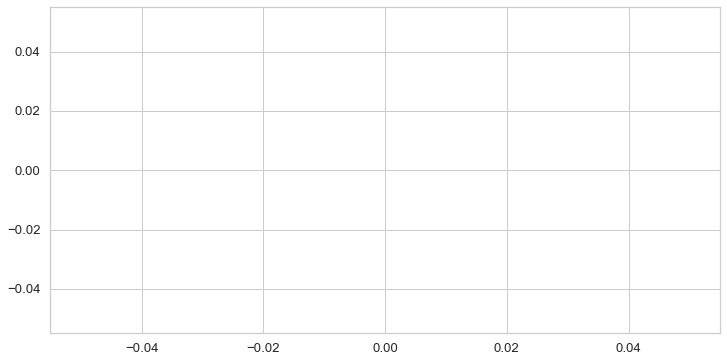

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reset index to access 'Filer Name' and 'Year' as columns
median_portfolio_tilt = median_portfolio_tilt.reset_index()

# Set style and font scale
sns.set(style="whitegrid", font_scale=1.2)

# Create separate plots for each manager
for manager in median_portfolio_tilt['Filer Name'].unique():
    plt.figure(figsize=(12, 6))
    manager_data = median_portfolio_tilt[median_portfolio_tilt['Filer Name'] == manager]
    sns.lineplot(data=manager_data, x="Year", y="Weight Difference", marker='o', markersize=8, linewidth=2)
    plt.title(f"Median Portfolio Tilt for {manager}")
    plt.xlabel("Year")
    plt.ylabel("Median Portfolio Tilt")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [28]:
x =['C', 'NXTL', 'TWX', 'EIX', 'LNC', 'FE', 'ELN', 'T', 'T', 'PVN', 'IBM', 'PVN', 'COST', 'VIAV', 'PFE', 'TGNA', 'HD', 'STI', 'FCEL', 'SFE', 'MRK', 'AKAM', 'FDC', 'DD', 'CEM', 'BEV', 'GPS', 'NEOL', 'FE', 'INTC', 'WFC', 'JAVA', 'MO', 'EVRG', 'INTC', 'DD', 'DELL', 'CCI', 'FALC', 'ITWO', 'BLS', 'DOV', 'MTB', 'VIAV', 'SGP', 'DNB', 'ITWO', 'SILI', 'PARA', 'PACW', 'DD', 'TXN', 'DIS', 'ODP', 'TT', 'JNY', 'JPM', 'MCD', 'AWE', 'NHI', 'PARA', 'HRB', 'BA', 'WPO', 'PVN', 'G', 'TZH', 'CMTN', 'DNB', 'AMAT', 'OSI', 'QQQ', 'Q', 'XLNX', 'PAYX', 'ALL', 'MCO', 'TGT', 'GL', 'GPS', 'MXIM', 'CRAY', 'WM']
len(x)

83